I'm using colab here because my laptop doesn't support tensorflow. I only took around 10% of the overall pictures because colab just die when I load more than this amount.

In [2]:
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
def train_id_to_path(x):
    return 'train/' + x + ".jpg"
def test_id_to_path(x):
    return 'test/' + x + ".jpg"

#Read in the data and drop unnecessary columns
train = pd.read_csv('train.csv')
train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

test = pd.read_csv('test.csv')
test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

#Add the .jpg extensions to the image file name ids
train["img_path"] = train["Id"].apply(train_id_to_path)
test["img_path"] = test["Id"].apply(test_id_to_path)

In [6]:
train.head()

,Id,Pawpularity,img_path
0,f0204d25be85b2f56778f25a63d16cef,88,train/f0204d25be85b2f56778f25a63d16cef.jpg
1,f0228ab82d01796ef319a40578a777d3,78,train/f0228ab82d01796ef319a40578a777d3.jpg
2,f02793c6e907c459f98e00bd08796301,65,train/f02793c6e907c459f98e00bd08796301.jpg
3,f039ad73bf1d511142571341c0ba9a32,32,train/f039ad73bf1d511142571341c0ba9a32.jpg
4,f0567f41c3059170ffbb1cee101beac0,4,train/f0567f41c3059170ffbb1cee101beac0.jpg


I read that because for this tabular data, the pawpularity score range from 0-100, which is pretty wide. Instead, we can change it into a classification problem, which means that there would be less categories within the range.

In [7]:
#binning columns to test models
train['two_bin_pawp'] = pd.qcut(train['Pawpularity'], q=2, labels=False)
train = train.astype({"two_bin_pawp": str})

train['four_bin_pawp'] = pd.qcut(train['Pawpularity'], q=4, labels=False)
train = train.astype({"four_bin_pawp": str})

train['ten_bin_pawp'] = pd.qcut(train['Pawpularity'], q=10, labels=False)
train = train.astype({"ten_bin_pawp": str})

For example, when the score is only classified within 2 bins, here's the result

In [8]:
train2bin_stats = train.groupby('two_bin_pawp')
train2bin_stats.describe()

Pawpularity                                                     
                   count       mean        std   min   25%   50%   75%    max
two_bin_pawp                                                                 
0                  371.0  23.328841   8.138976   2.0  20.0  25.0  30.0   33.0
1                  353.0  52.019830  17.361862  34.0  39.0  46.0  59.0  100.0

Now the train set would be:

In [9]:
train.head()

,Id,Pawpularity,img_path,two_bin_pawp,four_bin_pawp,ten_bin_pawp
0,f0204d25be85b2f56778f25a63d16cef,88,train/f0204d25be85b2f56778f25a63d16cef.jpg,1,3,9
1,f0228ab82d01796ef319a40578a777d3,78,train/f0228ab82d01796ef319a40578a777d3.jpg,1,3,9
2,f02793c6e907c459f98e00bd08796301,65,train/f02793c6e907c459f98e00bd08796301.jpg,1,3,9
3,f039ad73bf1d511142571341c0ba9a32,32,train/f039ad73bf1d511142571341c0ba9a32.jpg,0,1,4
4,f0567f41c3059170ffbb1cee101beac0,4,train/f0567f41c3059170ffbb1cee101beac0.jpg,0,0,0


In [10]:
#Set image size. Because the image size in the test data is 128 x 128 so I'll go with that
image_height = 128
image_width = 128

#define a function that accepts an image url and outputs an eager tensor
def path_to_eagertensor(image_path):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.resize_with_pad(image, image_height, image_width) #optional with padding to retain original dimensions
    image = tf.image.resize(image, (image_height, image_width))
    return image

In [11]:
print(train['img_path'][0])

train/f0204d25be85b2f56778f25a63d16cef.jpg


(960, 720, 3)


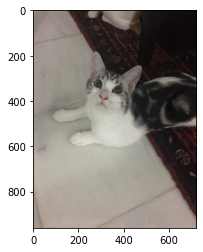

In [13]:
og_example_image = plt.imread('train/f0204d25be85b2f56778f25a63d16cef.jpg') 
print(og_example_image.shape)

plt.imshow(og_example_image)
plt.show()

In [14]:
example_image = path_to_eagertensor('train/f0204d25be85b2f56778f25a63d16cef.jpg')

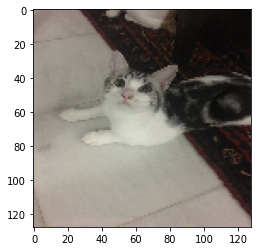

In [17]:
#show the image after tensor processing
plt.imshow(example_image)
plt.show()

In [21]:
import numpy as np

add the processed picture in train and test folder into a list

In [20]:
X = []
for img in train['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X.append(new_img_tensor)
    
print(type(X),len(X))
X = np.array(X)
print(type(X),X.shape)

<class 'list'> 724
<class 'numpy.ndarray'> (724, 128, 128, 3)


In [22]:
X_test = []
for img in test['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X_test.append(new_img_tensor)
    
print(type(X_test),len(X_test))
X_test = np.array(X_test)
print(type(X_test),X_test.shape)

<class 'list'> 8
<class 'numpy.ndarray'> (8, 128, 128, 3)


Here X is the data for modeling and predicting. The test image is provided by Petfinder for submission, which are not actually pet pictures and only has 8. So I'll take 20% of X as the actual test set.

In [23]:
y = train['Pawpularity']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

architecture

In [24]:
inputs = tf.keras.Input(shape=(image_height,image_width,3))

#start off with x just being those inputs
x = inputs

x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (7,7), strides = (2,2), padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)


x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs = inputs, outputs = output)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 61, 61, 16)        2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 61, 61, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 32)       128       
 hNormalization)                                             

Compile

In [26]:
model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae", "mape"])

data augmentation

In [27]:
data_augmentation = ImageDataGenerator(
    rotation_range = 15, 
    zoom_range = 0.15,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest")

Fit the model

In [28]:
history = model.fit(
    data_augmentation.flow(x_train,y_train,batch_size=32),
    validation_data = (x_test,y_test),
    steps_per_epoch = len(x_train) // 32,
    epochs = 60
)

Epoch 1/60
18/18 [==============================] - 17s 771ms/step - loss: 589.5962 - rmse: 24.2767 - mae: 18.8445 - mape: 83.6907 - val_loss: 1512.2533 - val_rmse: 38.8846 - val_mae: 33.6316 - val_mape: 86.9545
Epoch 2/60
18/18 [==============================] - 13s 719ms/step - loss: 432.0595 - rmse: 20.7802 - mae: 15.7743 - mape: 71.7162 - val_loss: 1385.2373 - val_rmse: 37.2155 - val_mae: 31.8145 - val_mape: 84.4735
Epoch 3/60
18/18 [==============================] - 13s 696ms/step - loss: 436.3828 - rmse: 20.8840 - mae: 15.4122 - mape: 76.1836 - val_loss: 1043.1688 - val_rmse: 32.2943 - val_mae: 26.5669 - val_mape: 80.4681
Epoch 4/60
18/18 [==============================] - 13s 713ms/step - loss: 443.6091 - rmse: 21.0562 - mae: 15.7760 - mape: 75.9589 - val_loss: 807.3325 - val_rmse: 28.4093 - val_mae: 22.0715 - val_mape: 77.2853
Epoch 5/60
18/18 [==============================] - 13s 715ms/step - loss: 421.3413 - rmse: 20.5206 - mae: 15.4904 - mape: 76.8918 - val_loss: 688.6993 -

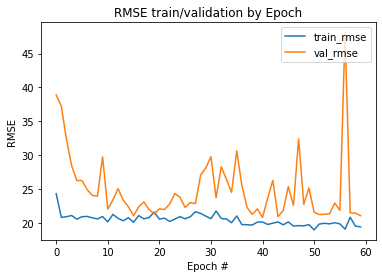

In [29]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
#plt.xticks(range(0,60))
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right")

Predict the test data

In [31]:
cnn_pred = model.predict(X_test)

In [34]:
# getting test ID with the score to the cnn dataframe
cnn = pd.DataFrame()
cnn['Id'] = test['Id']
cnn['Pawpularity'] = cnn_pred
cnn.to_csv('submission.csv',index=False)

In [33]:
cnn.head(10)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,28.190063
1,43a2262d7738e3d420d453815151079e,24.714249
2,4e429cead1848a298432a0acad014c9d,26.493828
3,80bc3ccafcc51b66303c2c263aa38486,24.891457
4,8f49844c382931444e68dffbe20228f4,27.055363
5,b03f7041962238a7c9d6537e22f9b017,26.440094
6,c978013571258ed6d4637f6e8cc9d6a3,26.678612
7,e0de453c1bffc20c22b072b34b54e50f,27.295107
